# Convolutional Denoising Autoencoder
- Denoising AutoEncoder란 노이즈가 추가된 $\tilde{x}$를 인풋으로 넣어서 노이즈가 없는 원 데이터인 $x$로 복구하여 이 차이를 최소화하는 방법
- 인풋을 복구하는 과정에서 복사가 아닌 중요한 특징들을 z에 인코딩하도록 학습이 가능
- Convolutional DAE는 CNN을 사용한 DAE

### AutoEncoder vs DAE
<table>
    <tr>
        <td>AutoEncoder</td>
        <td>Denoisong AutoEncoder</td>
    </tr>
    <tr>
        <td><img src="./asset/AutoEncoder.png" width="300" height="600"></td>
       <td><img src="./asset/Denoising_AutoEncoder.png" width="300" height="600"></td>
    </tr>
</table>


$$\text{AutoEncoder : } L(x, g(f(x))) $$

$$\rightarrow \text{DAE : } L(x, g(f(\tilde{x})))$$

## 1. Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms

import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

True


## 2. Load Dataset

In [2]:
model_dir = './save_models/MNIST/Deno_Autoencoder'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

mnist_train = dset.MNIST('./data/MNIST', train=True, transform=transforms.ToTensor(), target_transform=None,download=True)
mnist_test = dset.MNIST('./data/MNIST', train=False, transform=transforms.ToTensor(), target_transform=None,download=True)

batch_size = 100

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

## 3. Build Model
### 3.1 Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1),  # batch x 32 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
            nn.ReLU()
        )
                
    def forward(self, inputs):
        batch_size = inputs.size(0)
        out = self.conv1(inputs)
        out = self.conv2(out)
        out = out.view(batch_size, -1)
        return out

### 3.2 Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,2,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,64,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64,16,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,3,2,1,1),
            nn.ReLU()
        )
        
    def forward(self,inputs):
        batch_size = inputs.size(0)
        out = inputs.view(batch_size,256,7,7)
        out = self.deconv1(out)
        out = self.deconv2(out)
        return out

In [5]:
encoder = Encoder()
decoder = Decoder()

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

## 4. Loss Func & Optims

In [6]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss() # nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr=0.002)

In [7]:
try:
    encoder, decoder = torch.load(model_dir + '/conv_deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 5. Train

In [8]:
num_epoch = 10

for i in range(num_epoch):
    for j, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # 데이터 x에 noise를 주입시켜서 접근
        noise = init.normal_(torch.FloatTensor(batch_size, 1, 28, 28), 0, 0.1)
        noise = Variable(noise)
        
        if USE_CUDA:
            image = image.cuda()
            noise = noise.cuda()
            
        noise_image = image + noise
        
        output = encoder(noise_image)
        output = decoder(output)
        loss = loss_func(output, image)
        
        loss.backward()
        optimizer.step()
        
        if j % 10 == 0:        
            torch.save([encoder,decoder], model_dir + '/conv_deno_autoencoder.pkl')
            
    print("[%d/%d] MSE_loss : %0.5f"%(i+1, num_epoch, loss.item()))

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1/10] MSE_loss : 0.00218
[2/10] MSE_loss : 0.00159
[3/10] MSE_loss : 0.00152
[4/10] MSE_loss : 0.00119
[5/10] MSE_loss : 0.00126
[6/10] MSE_loss : 0.00123
[7/10] MSE_loss : 0.00115
[8/10] MSE_loss : 0.00111
[9/10] MSE_loss : 0.00122
[10/10] MSE_loss : 0.00110


## 6. Check Train Image

torch.Size([100, 28, 28])


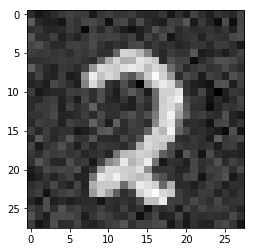

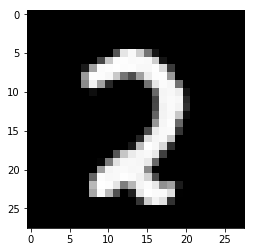

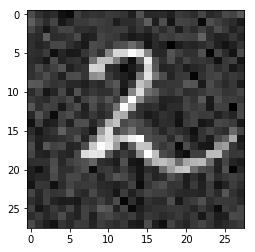

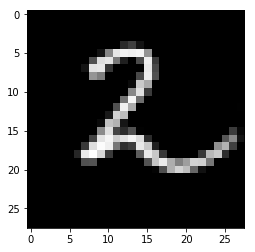

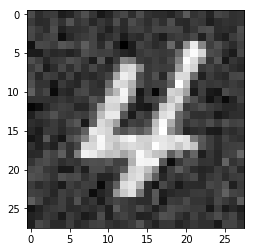

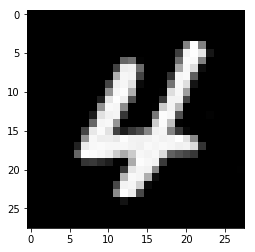

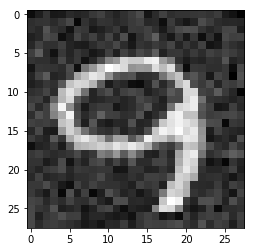

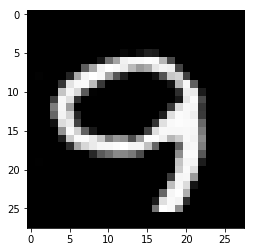

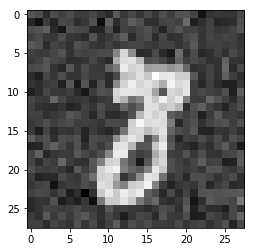

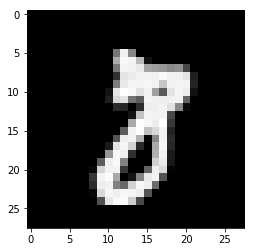

In [9]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.imshow(torch.squeeze(noise_image.cpu().data[i]).numpy(), cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()

## 7. Check Test Image

In [10]:
noise = init.normal_(torch.FloatTensor(batch_size,1,28,28),0,0.1)
noise = Variable(noise)

if USE_CUDA:
    noise = noise.cuda()

for i in range(1):
    for j,[image,label] in enumerate(test_loader):
        
        image = Variable(image,volatile=True)
        
        if USE_CUDA:
            image = image.cuda()
            
        noise_image = image + noise
        output = encoder(noise_image)
        output = decoder(output)
        loss = loss_func(output,image)
        
        if j % 10 ==0:
            print("[%d/%d] MSE_loss : %0.5f"%(i+1, 1, loss.item()))     

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


[1/1] MSE_loss : 0.00133
[1/1] MSE_loss : 0.00156
[1/1] MSE_loss : 0.00144
[1/1] MSE_loss : 0.00177
[1/1] MSE_loss : 0.00122
[1/1] MSE_loss : 0.00113
[1/1] MSE_loss : 0.00380
[1/1] MSE_loss : 0.00110
[1/1] MSE_loss : 0.00650
[1/1] MSE_loss : 0.00305


torch.Size([100, 28, 28])


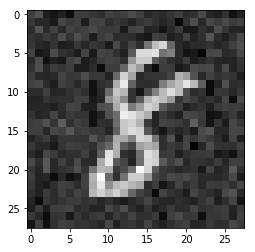

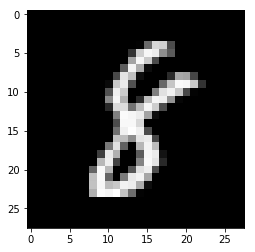

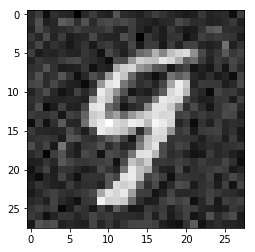

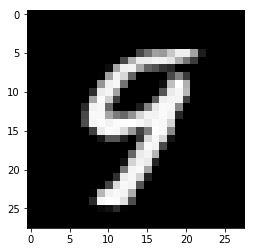

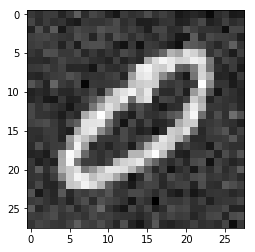

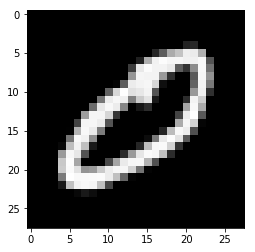

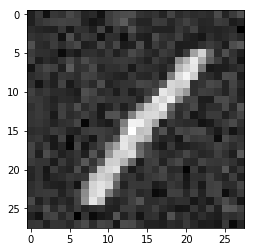

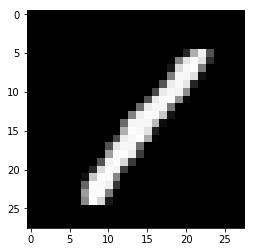

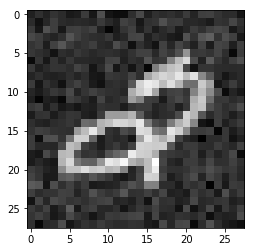

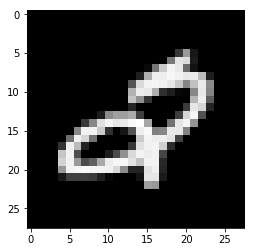

In [11]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.imshow(torch.squeeze(noise_image.cpu().data[i]).numpy(), cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()